<a href="https://colab.research.google.com/github/fornitroll/Object-Detection-with-PyTorch-Kyiv-/blob/master/Lecture_4_Single_Shot_Detection_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lecture4. Single Shot Detection. SSD

Hope you are doing well, and you have enough strength to proceed on this new lecture :)

Here we will be talking about another one-shot detector - SSD. I choose it instead of YoloV2 or V3, just to show some difference in these networks, while they are very similar and based on the same one-shot idea. So you will have experience with one more network.

What we will learn in this lecture:

- SSD VS YoloV1
- Box Encoding/Decoding. Scales & Aspect ratios
- Transformers
- Model
- Loss function


## SSD

### SSD vs YoloV1

Let's start by looking at the difference in SSD and YOLO architectures. As SSD came up only 6 months after the first YOLO, it adds many modifications that increase the quality of detection a lot.

What differs SSD from YoloV1:

- More box detectors
- No fully-connected layers
- Multi-Scale prediction
- Using anchor boxes
- Instead of selecting best bounding box in loss we threshold default boxes by IoU 0.5 and match them to ground truth boxes
- Using standard networks(like VGG) as a backbone instead of custom Darknet

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/ssd.png?raw=true">

**Number of boxes**

Let's calculate the number of boxes in SSD in total from SSD300 architecture, which we can see on the image.

After each feature map there 3x3 Conv is applied and there are N bboxes with 4 coordinate offsets each. So for instance Conv4_3 38×38×512 -> 38x38x(4 bboxes x (4 offsets + M Classes)). Suppose there are 20 classes plus one background, the output will be 38x38x(4x(4+21)) = 144 400, and the number of bounding boxes = 38x38x4 = 5776

Same for other conv layers:</br>
Conv7 19×19×6 = 2166 boxes (6 bboxes for each cell)</br>
Conv8_2 10×10×6 = 600 boxes (6 bboxes for each cell)</br>
Conv9_2 5×5×6 = 150 boxes (6 bboxes for each cell)</br>
Conv10_2 3×3×4 = 36 boxes (4 bboxes for each cell)</br>
Conv11_2 1×1×4 = 4 boxes (4 bboxes for each cell)</br>
Total: 5776 + 2166 + 600 + 150 + 36 +4 = 8732 bboxes

And YoloV1 have 7x7x2 = 98 boxes

This making SDD much better in detection then YoloV1, cause more boxes to give much better localization for detectors.

**Removed fully-connected layers**

These layers are eating much memory and much harder to train, so removing them giving good speed up.

**Multi-Scale detection**

In the last lecture 2, I was talking about the spatial pyramid pooling technique. And SDD uses it to increase the detection ability of objects with different sizes and removes the need to train the network on images with different sizes.

**Anchor boxes(Prior Boxes/Default box)**

Instead of giving network guess which box would predict what, we set default boxes to different aspect ratios. So each cell has up to 6 default boxes of a different shape. At the learning time, we match those default boxes to the ground truth boxes and leave by calculating IoU of them. If IoU > 0.5 we add box as a target by changing it cx,cy,w,h relative to the default box. Thus for one GT box, we can have many target boxes from different cells

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/1_St98vVQEqLndeV_-SeUc9Q.png?raw=true" />

So now we see how much better SSD with a difference to YoloV1

**So what we have together?**

The same as YoloV1 SSD breaks the image on cells, but it has few scales for that. For current SSD300 network it:38x32, 19x91, 10x10, 5x5, 3x3, 1x1. Which with up to 6 default boxes in each cell gives us 8732 boxes of prediction.

Instead of encoding classes and coords together SSD has two heads one for localization and one for classification. Instead of confidence, we add background class which is saying that there is nothing interesting.

All coordinates are relative to the default box and also we use normalization for them (variance/scaling)

As a backbone network, we use here ResNet50 instead of VGG and cut it in such a way to get needed sizes for our grids.

In [0]:
import time
import os
import sys

import cv2
import numpy as np
import random
from PIL import Image, ImageDraw, ImageFile
# fix bugs with loading png files
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.hub import load_state_dict_from_url
from torchvision.ops.boxes import batched_nms


from google.colab import files
def upload(path):
    uploaded = files.upload()
    with open(path,'wb') as fp:
        fp.write(uploaded[list(uploaded.keys())[0]])
 
def download(path):
    files.download(path)

### Model
Let's first build SSD model as it the simplest step

In [0]:
class ResNet50Backbone(nn.Module):

    def __init__(self, freeze=True):
        super(ResNet50Backbone, self).__init__()

        model = models.resnet50(pretrained=True)
        if freeze:
            model.requires_grad_(False)
        else:
            for name, parameter in model.named_parameters():
                if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                    parameter.requires_grad_(False)
        self.x = nn.Sequential(*list(model.children())[:7])
        # output channels for each additional features block
        self.out_channels = [1024, 512, 512, 256, 256, 256]
        # remove strides to get correct feature spatial size
        conv4_block1 = self.x[-1][0]
        conv4_block1.conv1.stride = (1, 1)
        conv4_block1.conv2.stride = (1, 1)
        conv4_block1.downsample[0].stride = (1, 1)

    def forward(self, x):
        return self.x(x)

class SSD(nn.Module):

    def __init__(self, backbone, classes=21, freeze=True):
        super(SSD, self).__init__()

        self.base = backbone

        self.classes = classes  
        self.num_defaults = [4, 6, 6, 6, 4, 4]
        self.additional_blocks = []
        self.loc = []
        self.conf = []

        # adding additional blocks before loc and conf heads
        self.build_additional_features(self.base.out_channels)

        # creating loc and conf heads
        for nboxes, channels in zip(self.num_defaults, self.base.out_channels):
            self.loc.append(nn.Conv2d(channels, nboxes * 4, kernel_size=3, padding=1))
            self.conf.append(nn.Conv2d(channels, nboxes * self.classes, kernel_size=3, padding=1))

        self.loc = nn.ModuleList(self.loc)
        self.conf = nn.ModuleList(self.conf)

        self._init_weights()

    def build_additional_features(self, input_size):
        for i, (input_size, output_size, channels) in enumerate(zip(input_size[:-1], input_size[1:], [256, 256, 128, 128, 128])):
            # we dont use bias because we use batchnorm that should center data
            # batch norm minimize overfit by doing normalization of data over batch
            if i < 3:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, padding=1, stride=2, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )
            else:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )

            self.additional_blocks.append(layer)

        self.additional_blocks = nn.ModuleList(self.additional_blocks)

    def _init_weights(self):
        # initialize weight for convolutions
        layers = [*self.additional_blocks, *self.loc, *self.conf]
        for layer in layers:
            for param in layer.parameters():
                if param.dim() > 1: nn.init.xavier_uniform_(param)

    def bbox_view(self, src):
        # Apply heads and reshape
        ret = []
        for s, l, c in zip(src, self.loc, self.conf):
            ret.append((l(s).view(s.size(0), 4, -1), c(s).view(s.size(0), self.classes, -1)))

        locs, confs = list(zip(*ret))
        locs, confs = torch.cat(locs, 2).contiguous(), torch.cat(confs, 2).contiguous()
        return locs, confs

    def forward(self, x):
        x = self.base(x)

        detection_feed = [x]
        for i,l in enumerate(self.additional_blocks):
            x = l(x)
            detection_feed.append(x)

        # Feature Map 38x38x4, 19x19x6, 10x10x6, 5x5x6, 3x3x4, 1x1x4
        locs, confs = self.bbox_view(detection_feed)

        # For SSD 300, shall return nbatch x 8732 x {classes, locations} results
        return locs, confs


In [0]:
# checking model
x = torch.rand((2,3,300,300))
l,c = SSD(ResNet50Backbone())(x)
print(l.shape, c.shape)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 21.5MB/s]


torch.Size([2, 4, 8732]) torch.Size([2, 21, 8732])


### Transformers & Datasets

#### Default boxes

To build default boxes we need a number of features (we have 6), aspect ratios and scale for each feature size.

**The scale of the default boxes for each feature map is computed as:**

$s_k = smin + \frac{smax − smin}{m − 1} (k − 1), k ∈ [1, m]$

Where the lowest layer has a scale of **smin**  and
the highest layer has a scale of **smax**, and all layers in between are regularly spaced. **m** - number of feature maps (currently we have 6 of them)</br>The bigger feature the less scale for a box we have (predicting smaller objects)

**Aspect ratios**

Default aspect ratios is: $a_r \in\{1,2,3,1/2,1/3\}$
The number of aspect ratios can be changed for some specific cases of optimization, but don't forget that heads also should be changes to return the needed amount of boxes. 

**Computing coordinates of boxes**

for ratio 1 additionaly add box with scale $s_k = \sqrt{s_{k}s_{k+1}}$

$w = s_k\sqrt{a_r}, h = s_k/\sqrt{a_r}$

$x_c, y_c = \{\frac{i+0.5}{|f_k|}, \frac{j+0.5}{|f_k|}\}$, where $|f_k|$ - size of the feature and $i,j \in [0, |f_k|)$





In [0]:
from math import sqrt
import itertools

class DefaultBoxes(object):
    def __init__(self, fig_size, feat_size, aspect_ratios, \
                       scale_xy=0.1, scale_wh=0.2, scale_min=0.07, scale_max=0.9):

        self.feat_size = feat_size
        self.fig_size = fig_size
        self.scale_min = scale_min
        self.scale_max = scale_max

        self.scale_xy_ = scale_xy
        self.scale_wh_ = scale_wh

        self.aspect_ratios = aspect_ratios

        self.default_boxes = []

        for idx, sfeat in enumerate(self.feat_size):
            sk = scale_min + ((scale_max - scale_min)/(len(self.feat_size)-1))*(idx)
            sk_next = scale_min + ((scale_max - scale_min)/(len(self.feat_size)-1))*(idx+1)
            
            all_sizes = []
            for alpha in self.aspect_ratios[idx]:
                w, h = sk*sqrt(alpha), sk/sqrt(alpha)
                all_sizes.append((w,h))
            # for aspect 1 adding additional box
            # FIXED
            # here was a typo, now sk calculating by formula, as it should
            sk = sqrt(sk*sk_next)
            w, h = sk*sqrt(1.), sk/sqrt(1.)
            all_sizes.append((w,h))
            
            for w, h in all_sizes:
                for i, j in itertools.product(range(sfeat), repeat=2):
                    cx, cy = (j+0.5)/sfeat, (i+0.5)/sfeat
                    self.default_boxes.append((cx, cy, w, h))

        self.dboxes = torch.tensor(self.default_boxes)
        # make values in interval [0,1]
        self.dboxes.clamp_(min=0, max=1)
        # For IoU calculation
        self.dboxes_ltrb = self.dboxes.clone()
        self.dboxes_ltrb[:, 0] = self.dboxes[:, 0] - 0.5 * self.dboxes[:, 2]
        self.dboxes_ltrb[:, 1] = self.dboxes[:, 1] - 0.5 * self.dboxes[:, 3]
        self.dboxes_ltrb[:, 2] = self.dboxes[:, 0] + 0.5 * self.dboxes[:, 2]
        self.dboxes_ltrb[:, 3] = self.dboxes[:, 1] + 0.5 * self.dboxes[:, 3]
        self.dboxes_ltrb.clamp_(min=0, max=1)
        # FIXED
        # LTRB boxes added clamp, cause new values can be out of interval [0,1]

    @property
    def scale_xy(self):
        # also called variance
        return self.scale_xy_

    @property
    def scale_wh(self):
        return self.scale_wh_

    def __call__(self, order="ltrb"):
        if order == "ltrb": return self.dboxes_ltrb
        if order == "xywh": return self.dboxes

def default_boxes_300():
    # we use default values
    figsize = 300
    feat_size = [38, 19, 10, 5, 3, 1]
    aspect_ratios = [[1.,2.,0.5], [1.,2.,0.5,3.,1./3], [1.,2.,0.5,3.,1./3], [1.,2.,0.5,3.,1./3], [1.,2.,0.5], [1.,2.,0.5]]
    scale_min=0.07
    scale_max=0.9
    dboxes = DefaultBoxes(figsize, feat_size, aspect_ratios, scale_min=scale_min, scale_max=scale_max)
    return dboxes

In [0]:
default_boxes_300().dboxes.shape

tensor([[0.0132, 0.0132, 0.0700, 0.0700],
        [0.0395, 0.0132, 0.0700, 0.0700],
        [0.0658, 0.0132, 0.0700, 0.0700],
        ...,
        [0.5000, 0.5000, 1.0000, 0.6364],
        [0.5000, 0.5000, 0.6364, 1.0000],
        [0.5000, 0.5000, 0.9795, 0.9795]])
tensor([[-0.0218, -0.0218,  0.0482,  0.0482],
        [ 0.0045, -0.0218,  0.0745,  0.0482],
        [ 0.0308, -0.0218,  0.1008,  0.0482],
        ...,
        [ 0.0000,  0.1818,  1.0000,  0.8182],
        [ 0.1818,  0.0000,  0.8182,  1.0000],
        [ 0.0103,  0.0103,  0.9897,  0.9897]])


torch.Size([8732, 4])

Now let's build util to build target boxes and decode resulting boxes from model

To encode our GT boxes first we need:
1. Match them with default boxes by IoU > 0.5 (by paper). 
2. Matched default boxes we replace with GT boxes 
3. All other boxes classes are set to the 'background' (zero index).
4. Convert coordinates to the relative to the default boxes. Thus classes with background will have zeros in coordinates.
5. Normalize coordinates by scale(variance) xy = 0.1, wh = 0.2.

Coordinates relativnes calculated like this:

 $xy = (xy - default\_boxes\_xy)/(scale\_xy*default\_boxes\_wh)$

 $wh = log_e(wh / default\_boxes\_wh)/scale\_wh$

 To decode just revert operations in encoding for coordinates.

 #### Scale(Variance)
 It's very complicated to find somewhere information about that. I think that name "Variance" here is missleading and this is not variance but standart deviation. And thus we have basicaly normalization operation(where mean ~= 0) for coordinates, the same as you do for input images. It show how much GT boxes coordinates differs from default boxes in dataset. You can calculate this data based on your dataset, but in most cases these values are working ok.

 


In [0]:
def calc_iou_tensor(box1, box2):
    """ param: box1  tensor (N, 4) (x1,y1,x2,y2)
        param: box2  tensor (M, 4) (x1,y1,x2,y2)
        output: tensor (N, M)
    """
    N = box1.size(0)
    M = box2.size(0)

    box1 = box1.unsqueeze(1).expand(-1, M, -1)
    box2 = box2.unsqueeze(0).expand(N, -1, -1)

    # Left Top & Right Bottom
    lt = torch.max(box1[:,:,:2], box2[:,:,:2])
    rb = torch.min(box1[:,:,2:], box2[:,:,2:])

    delta = rb - lt
    delta[delta < 0] = 0
    intersect = delta[:,:,0]*delta[:,:,1]

    delta1 = box1[:,:,2:] - box1[:,:,:2]
    area1 = delta1[:,:,0]*delta1[:,:,1]
    delta2 = box2[:,:,2:] - box2[:,:,:2]
    area2 = delta2[:,:,0]*delta2[:,:,1]

    iou = intersect/(area1 + area2 - intersect)
    return iou


class BoxUtils:
    """
        Util to encode/decode target/result boxes

        param: dboxes - DefaultBoxes instance
    """

    def __init__(self, dboxes):
        self.dboxes = dboxes(order="ltrb")
        self.dboxes_xywh = dboxes(order="xywh")
        self.nboxes = self.dboxes.size(0)

        self.scale_xy = dboxes.scale_xy
        self.scale_wh = dboxes.scale_wh

    def encode(self, bboxes, labels_in, criteria = 0.5, num_classes=21):

        ious = calc_iou_tensor(bboxes, self.dboxes) # [N_bboxes, num_default_boxes]
        best_dbox_ious, best_dbox_idx = ious.max(dim=0) # [num_default_boxes], [num_default_boxes]
        best_bbox_ious, best_bbox_idx = ious.max(dim=1) # [N_bboxes], [N_bboxes]

        # set best ious 2.0
        # this needed to not filter out this bboxes on next step
        best_dbox_ious.index_fill_(0, best_bbox_idx, 2.0)

        # filter out dboxes with IoU <= criteria
        masks = best_dbox_ious > criteria
        # setting all labels of filtered out dboxes to zero(background)
        labels_out = torch.zeros(self.nboxes, dtype=torch.long)
        labels_out[masks] = labels_in[best_dbox_idx[masks]]

        # setting ghound trouth boxes on place of best matched default boxes
        # and convert (x1,y1,x2,y2) format to (xc,yc,w,h)
        bboxes_out = self.dboxes.clone()
        bboxes_out[masks, :] = bboxes[best_dbox_idx[masks], :]
        # Transform format to xywh format
        x, y, w, h = 0.5*(bboxes_out[:, 0] + bboxes_out[:, 2]), \
                     0.5*(bboxes_out[:, 1] + bboxes_out[:, 3]), \
                     -bboxes_out[:, 0] + bboxes_out[:, 2], \
                     -bboxes_out[:, 1] + bboxes_out[:, 3]

        # make coordinates to be offset to default boxes and encode variance for xy and wh
        bboxes_out[:, 0] = (x - self.dboxes_xywh[:, 0])/(self.scale_xy*self.dboxes_xywh[:, 2])
        bboxes_out[:, 1] = (y - self.dboxes_xywh[:, 1])/(self.scale_xy*self.dboxes_xywh[:, 3])
        bboxes_out[:, 2] = torch.log(w/self.dboxes_xywh[:, 2])/self.scale_wh
        bboxes_out[:, 3] = torch.log(h/self.dboxes_xywh[:, 3])/self.scale_wh
        return bboxes_out, labels_out

    def decode(self, bboxes):
        
        xy = self.dboxes_xywh[:,:2]
        wh = self.dboxes_xywh[:,2:]

        # don't forget that we need to remove variance from output 
        _xy = (bboxes[:,:2]*self.scale_xy*wh) + xy 
        _wh2 = (torch.exp(bboxes[:,2:]*self.scale_wh)*wh)/2 
        xy1 = (_xy - _wh2)
        xy2 = (_xy + _wh2)
        boxes = torch.cat([xy1,xy2],dim=-1)

        return boxes

  

#### Augmentation
As we start doing heavy things like multi-class multi-object detection which needs a big amount of data to train, we need to know some things about how to increase data variability ещ make our solution more generalized. And here is come Augmentation.

It may include things like this:
- Increase dataset size
- Rebalance classes by creating more augmented images on classes that have a low presence in dataset
- Create new data that not present in a dataset like adding lighting, noise, weather conditions and more
- Create synthetic rendered data from 3d
- Create synthetic data generated by another network (GANs)
- etc

As we working with Object Detection task we need to remember:
- Crops are a good way to prepare your model to different input not only by size but also by quality/blurring etc. Wich mathematically means that you show different distributions of low-level features to your network.
- Adding lighting, noise, etc. Working as a regularizer by making some data not present and thus pushing the model to be more intellectual 
- Flips/Rotations increase your dataset inputs, as a model, not rotation invariant (But this can be handled by Spatial Transform Networks if needed.)
- If you add synthetic data always freeze low-level features in another way your test prediction accuracy will get drop ~20-30%

SSD Paper is saying about using crops with different IoU with GT boxes, but we will not use this, cause training time already will be long, but if you want to train a really accurate model you need to use as much as possible of different augmentation in your training.
But there is a drawback to this. The more variability you have the bigger batch better to use, in other cases BatchNorm will work not very good, and training will be not stable. In the paper, they used batch 32 and we will use 10, cause we can afford more.

In [0]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, bboxes):
        if random.random() < self.p:
            bboxes[:, 0], bboxes[:, 2] = 1.0 - bboxes[:, 2], 1.0 - bboxes[:, 0]
            return image.transpose(Image.FLIP_LEFT_RIGHT), bboxes
        return image, bboxes

class SSDTransformVoc:
    def __init__(self, dboxes, size=(300,300), augmentation=False, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.size = size
        self.encoder = BoxUtils(dboxes)
        # base transform for images
        self.img_ts = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(), # converts to [0,1] interval
            transforms.Normalize(mean=mean, std=std)
        ])        
        self.classes = [
            "bg","person", "bird", "cat", "cow", "dog", "horse", "sheep",
            "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
            "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"
        ] # bg+20 classes

        self.img_trans_aug = transforms.Compose([
            transforms.Resize(self.size),
            transforms.ColorJitter(brightness=0.125, contrast=0.5,
                saturation=0.5, hue=0.05
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
        self.img_trans = transforms.Compose([
            transforms.Resize(self.size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
        self.hflip = RandomHorizontalFlip()
        self.augmentation = augmentation
       
    def box_resize(self, img_shape, box):
        """Method to resize bounding box"""
        w,h = img_shape
        xs,ys = self.size[0]/w, self.size[1]/h
        box = np.array([int(box[0])*xs/self.size[0],int(box[1])*ys/self.size[1],int(box[2])*xs/self.size[0],int(box[3])*ys/self.size[1]])
        return box
        
    def __call__(self, img, target):
        boxes = []
        labels = []
        if isinstance(target, dict) and 'annotation' in target:
            # voc bboxes annotation can be list if many or dict if one (never do like this)
            objects = target['annotation']['object'] if isinstance(target['annotation']['object'], list) else [target['annotation']['object']]
            for bb in objects:
                b = bb['bndbox']
                b = [b['xmin'],b['ymin'],b['xmax'],b['ymax']]
                boxes.append(self.box_resize(img.size,b))
                labels.append(self.classes.index(bb['name']))
        else:
            for bb in target:
                boxes.append(self.box_resize(img.size,bb))
                labels.append(1)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        if self.augmentation:
            img, boxes = self.hflip(img, boxes)
            img = self.img_trans_aug(img).contiguous()
        else:
            img = self.img_trans(img).contiguous()

        bbox, label = self.encoder.encode(boxes, labels, num_classes=len(self.classes))
        return img, (bbox, label)


In [0]:
!wget --quiet https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

^C
Archive:  PennFudanPed.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of PennFudanPed.zip or
        PennFudanPed.zip.zip, and cannot find PennFudanPed.zip.ZIP, period.


In [0]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        # path to the dataset
        self.root = root
        # transformation for image and targets
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        '''This method return one time(not batch), image and target'''
        
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        targets = []
        # get bounding box coordinates for one mask other paint over
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            targets.append([xmin, ymin, xmax, ymax])
            
        if self.transforms is not None:
            img, targets = self.transforms(img, targets)

        return img, targets

    def __len__(self):
        '''this method return len of dataset'''
        return len(self.imgs)

In [0]:

ds = datasets.VOCDetection('./voc', download=True, transforms=SSDTransformVoc(default_boxes_300()))

  0%|          | 835584/1999639040 [00:00<04:01, 8281254.88it/s]

100%|█████████▉| 1994276864/1999639040 [00:20<00:00, 93946732.19it/s]

As always testing our loader with all transformations

In [0]:
def test_dataloading(ds, dboxes, size=300, scale_xy=0.1, scale_wh=0.2):

    bu = BoxUtils(dboxes)

    def denorm(x):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        return (x * std) + mean

    for i in range(4):
        img, ts = ds[i]
        bboxes, labels = ts[0],ts[1]
        img = np.ascontiguousarray(denorm(img.numpy().transpose(1,2,0).copy())*255).astype(np.uint8)
        w,h = img.shape[:2]

        res = bu.decode(bboxes)

        mask = (labels > 0)
        res = res[mask].numpy()
        for bb in res:    
            img = cv2.rectangle(img, (int(bb[0]*w), int(bb[1]*h)), (int(bb[2]*w), int(bb[3]*h)), (0, 255, 0), 2)

        plt.imshow(img)
        plt.show()
        print('Shape:',img.shape,'Boxes:',len(bboxes))

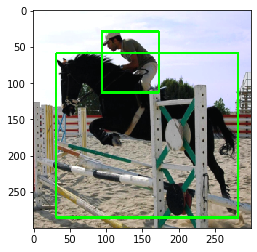

Shape: (300, 300, 3) Boxes: 8732


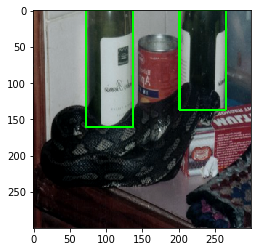

Shape: (300, 300, 3) Boxes: 8732


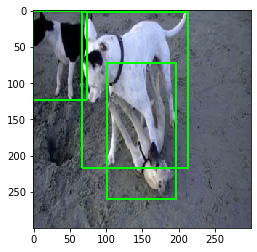

Shape: (300, 300, 3) Boxes: 8732


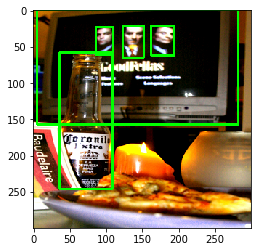

Shape: (300, 300, 3) Boxes: 8732


In [0]:
dboxes = default_boxes_300()
ds = datasets.VOCDetection('./voc', transforms=SSDTransformVoc(dboxes,augmentation=True))
# ds = PennFudanDataset('./PennFudanPed', transforms=SSDTransformVoc(dboxes))
test_dataloading(ds, dboxes)

### Loss

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/ssd_loss.png?raw=true">

Our loss consists of 2 losses: localization and class confidence. We don't have object presence confidence like in YoloV1, cause instead of this we add additional class 'Background'.

Both losses are calculated against matched boxes only + negative boxes with Background in proportion 1:3. All other boxes ignored in calculations. (For this responsible $x_{ij}^k$ param in a formula)

**Localisation**</br>
For localisation we use Smooth L1 loss.
$Smooth L_{1} = \begin{cases}|x| & \text{if $|x|>\alpha$;} \\
\frac{1}{|\alpha|}x^2 & \text{if $|x| \leq \alpha$}\end{cases}$

Which can be interpreted as a combination of L1-loss and L2-loss. It behaves as L1-loss when the absolute value of the argument is high, and it behaves like L2-loss when the absolute value of the argument is close to zero. This force network to be less sensitive to outliers(with big error). But in my experience, I didn't saw much difference between L1 and SmoothL1, but let's believe guys with big GPU clusters who run more tests then i. (Always test different thing and write down somewhere your results, it will help you in future to make faster decisions)

$g_j^*$ - params on the formula is basically our GT box normalization with "variance/scale" which we did in our BoxUtils class

**Class confidence**</br>

For confidence here used Cross-Entropy loss $CE = -log(c_i^p)$, which is standard loss for label prediction. ($c_i^p$ param in it it's Softmax function).

But let's first look at our dataset class distribution:


In [0]:
from collections import Counter
def viz_voc(ds):
    '''
        Vizualize class and w,h distribution on dataset
    '''
    cls = Counter()
    w, h = [], []
    total = len(ds)
    total_objects = 0
    for i, (img, t) in enumerate(ds):
        objects = t['annotation']['object'] if isinstance(t['annotation']['object'], list) else [t['annotation']['object']]
        total_objects += len(objects)
        for bb in objects:
            cls[bb['name']] += 1
            b = bb['bndbox']
            w.append(int(b['xmax']) - int(b['xmin']))
            h.append(int(b['ymax']) - int(b['ymin']))
        total += 1
    classes = np.array(list(cls.most_common(50)))
    w = np.array(w).astype(np.float16)
    h = np.array(h).astype(np.float16)
    print('Total images:', total)
    print('Total objects:', total_objects, 'Object per image:', total_objects/total)
    x = np.arange(20)
    plt.figure(figsize=(14,14))
    plt.xticks(x, np.flip(classes[:,0]), rotation='vertical')
    plt.bar(x, np.flip(classes[:,1]).astype(np.float16))
    # plt.set_label('Class counts')
    plt.show()
    print('Box Width distribution')
    plt.hist(w)
    plt.show()
    print('Box Height distribution')
    plt.hist(h)
    plt.show()

1999642624it [06:50, 5466553.23it/s]                                

Total images: 11434
Total objects: 15774 Object per image: 1.3795697043904145


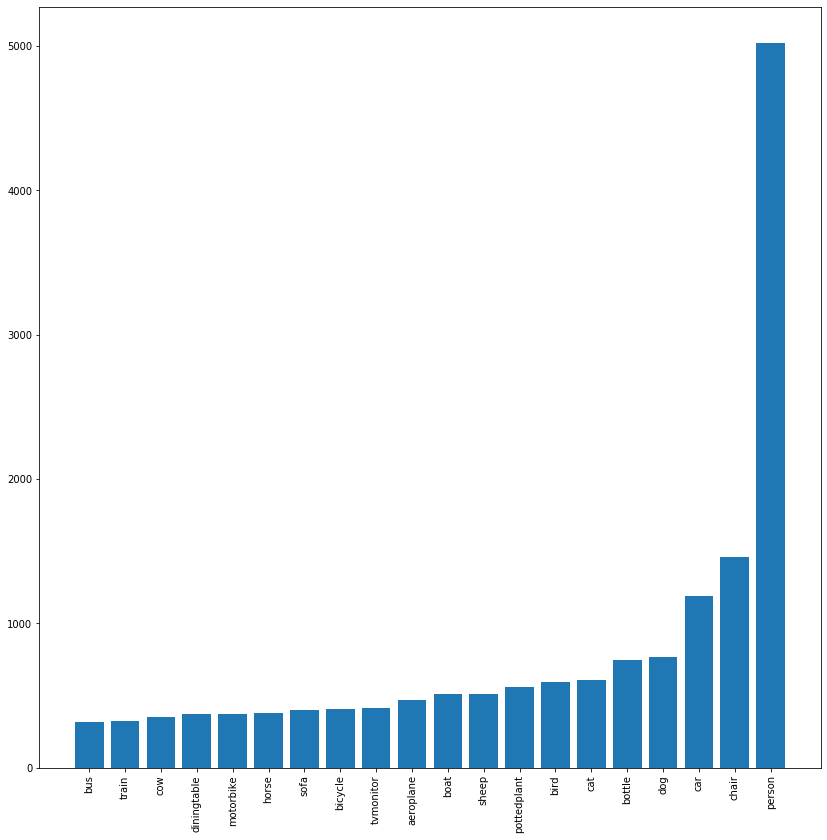

Box Width distribution


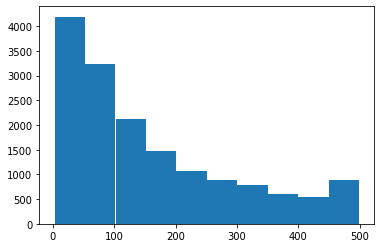

Box Height distribution


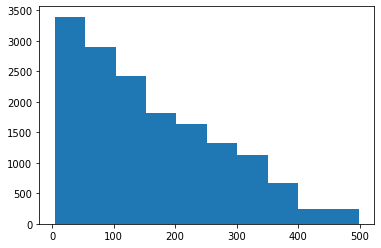

In [0]:
ds = datasets.VOCDetection('./voc')
viz_voc(ds)

As we see we have 3 classes: background + person, car, chair(too many people are sitting, it's not healthy, don't forget to move and doing physical exercises). This means that if we use CrossEntropy then the network will see more people in any object. And the question is this correct distribution for our task or not. If not then we need to fix it somehow to get better results.

**When distribution correct**
So this dataset was gathered mostly in cities, and in cities, we will see more cars and people and chairs, so for cities, this class distribution is ok.
But if for example, we want to detect objects somewhere in nature, then we will not see so many people and cars, this distribution should be fixed.
Ideally, dataset distribution should be the same as the distribution of objects that you are trying to detect in an area that you choose. More simple is to make all classes equal.


To make them more equal we need to weight classes, but this is not so simple and nice. But there is another way - use Focal loss, which does weighting automatically.

Focal loss reduces the loss of well-trained classes. So when some class will be trained enough his influence on loss will be reduced.

$FL(p_t) = -(1-p_t)^\gamma\log{(p_t)}$

As you see it's the same CE loss but with small addition $(1-p)^\gamma$

In the paper, guys recommend using $\gamma= 2.0$ 

**Hard Negative Minning**

If we use CE instead of FL we need to use this technique to lower the influence of background boxes on our loss. To do this we order background boxes by their confidence and leave just Top N of them. Where N = 3 * Object Boxes, N < Total GT Object Boxes.

But if we use Focal loss paper states that we don't need this, but on practice, if we use both Hard Negative Minning & Focal loss, the model will converge faster.
As we want to see results today we will use both FL and HNM.

In [0]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=2, size_average=False):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, input, target):
        ce = self.ce(input,target)
        pt = (-1*ce).exp()
        loss = (1 - pt)**self.gamma * ce
        if self.size_average: 
            return loss.mean()
        else: 
            return loss

class Loss(nn.Module):
    """
        Implements the loss as the sum of the followings:
        1. Confidence Loss: All labels, with hard negative mining
        2. Localization Loss: Only on positive labels
        Suppose input dboxes has the shape 8732x4
    """
    def __init__(self, alpha=1, hard_negative_minning=True):
        super(Loss, self).__init__()
        self.alpha = alpha
        self.sl1_loss = nn.SmoothL1Loss(reduction='none')
        # you can try to train with both of the loss and look at difference in results over same number of steps
        self.con_loss = FocalLoss(size_average=False)# nn.CrossEntropyLoss(reduction='none')
        self.hard_negative_minning = hard_negative_minning

    def forward(self, ploc, plabel, gloc, glabel):
        """
            ploc, plabel: Nx4x8732, Nxlabel_numx8732
                predicted location and labels
            gloc, glabel: Nx4x8732, Nx8732
                ground truth location and labels
        """
        gloc = gloc.transpose(2,1)
        mask = glabel > 0
        pos_num = mask.sum(dim=1)

        # sum on four coordinates, and mask
        sl1 = self.sl1_loss(ploc, gloc).sum(dim=1)
        sl1 = (mask.float()*sl1).sum(dim=1)

        # hard negative mining
        con = self.con_loss(plabel, glabel)
        if self.hard_negative_minning:
            # postive mask will never selected
            con_neg = con.clone()
            con_neg[mask] = 0
            con_neg_top, con_idx = con_neg.sort(dim=1, descending=True) # aka 8000,1734,2000,...
            _, con_rank = con_idx.sort(dim=1) # aka 1,2,0,..

            # number of negative three times positive
            neg_num = torch.clamp(3*pos_num, max=mask.size(1)).unsqueeze(-1) # Nx1
            
            neg_mask = con_rank < neg_num

            # summing positive confidence and negative confidence 
            closs = (con*(mask.float() + neg_mask.float())).sum(dim=1)
        else:
            closs = con.sum(dim=1)

        total_loss = sl1 + self.alpha*closs
        metrics = {'loc':sl1.mean().detach().item(), 'conf':closs.mean().detach().item()}
        # avoid no object detected
        num_mask = (pos_num > 0).float()
        pos_num = pos_num.float().clamp(min=1e-6)
        ret = (total_loss*num_mask/pos_num).mean(dim=0)
        return ret,metrics

### Training PennFudanPed
Let's train on simple dataset first to see that model converge

In [0]:
torch.manual_seed(42)

dboxes = default_boxes_300()
ds = PennFudanDataset('./PennFudanPed', transforms=SSDTransformVoc(dboxes, augmentation=True))
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
# we will have same split here everytime because of setting manual seed
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

loader = DataLoader(train_dataset, batch_size=6, pin_memory=True, drop_last=True) 
epochs = 230 # its enough to see good result
device = torch.device("cuda")
model =  SSD(ResNet50Backbone(), classes=21, freeze=True)
# state = torch.load('./ssd300.pth')
# model.load_state_dict(state)
model = model.to(device)
loss_f = Loss()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

st = time.time()
model.train()
for e in range(epochs):
    t = 0
    loss_avg = 0
    for i, (img, target) in enumerate(loader):
        img = img.to(device)
        boxes, labels = target[0].to(device), target[1].to(device)
        # before each iteration we clear all gradients calculated before 
        optimizer.zero_grad()
        rboxes, rlabels = model(img)
        loss, m = loss_f(rboxes, rlabels, boxes, labels)
        # calculating gradients
        loss.backward()
        # optimizing
        optimizer.step()
        # .item() is simple way to get value from scalar
        loss_avg += loss.item()
        t += 1

    print(f'Epoch: {e}/{epochs} Loss:{loss_avg/t}, LR:{optimizer}')
    print(m)
    try:
        torch.save(model.state_dict(), './ssd300.pth')
    except KeyboardInterrupt as e:
        print('SAVING !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        torch.save(model.state_dict(), './ssd300.pth')
        raise e
    scheduler.step(loss_avg/t)
    t = 0
    loss_avg = 0
    
print('Training time:', time.time()-st)

In [0]:
# we use batches_nms cause we can have many classes of different objects
from torchvision.ops.boxes import batched_nms

def test(model_path, model_class, bu, input, num=6, thresh=0.7, iou_threshold=0.5, size=300, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    classes = [
        "bg","person", "bird", "cat", "cow", "dog", "horse", "sheep",
        "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
        "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"
    ]

    def denorm(x):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        return (x * std) + mean

    state = torch.load(model_path)
    model = model_class.cpu()
    model.load_state_dict(state)
    model.eval()
    img_ts = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(), # converts to [0,1] interval
        transforms.Normalize(mean=mean, std=std)
    ])  
    total = 0
    iou_avg = 0
    if isinstance(input, Image.Image):
        input = [[img_ts(input), None]]
    for img, target in input:
        img = img.view((1,)+img.shape)
        st = time.time()
        rboxes, rlabels = model(img)
        print('Inference time:', time.time()-st)
        st = time.time()

        rboxes, rlabels = rboxes[0].transpose(1,0), rlabels[0]
        img = (denorm(img[0].numpy().transpose(1,2,0).copy())*255).astype(np.uint8)
        w,h = img.shape[:2]

        bboxes = bu.decode(rboxes)
        scores, labels = F.softmax(rlabels, dim=0).max(dim=0)
        mask = (labels > 0)
        labels = labels[mask]
        scores = scores[mask]
        bboxes = bboxes[mask]
        # print(scores)
        mask = (scores > thresh)
        labels = labels[mask]
        scores = scores[mask]
        bboxes = bboxes[mask]
        
        
        print('Boxes:',bboxes.shape[0])
        print('Mod time:', time.time()-st)
        st = time.time()
        idx = batched_nms(bboxes, scores, labels, iou_threshold=iou_threshold).numpy().astype(np.uint64)
        print('NMS time:', time.time()-st)
        labels = labels.detach().numpy().astype(np.uint8)
        scores = scores.detach().numpy()
        bboxes = bboxes.detach().numpy()

        for i in idx:
            b = bboxes[i] 
            img = cv2.rectangle(img, (int(b[0]*size), int(b[1]*size)), (int(b[2]*size), int(b[3]*size)), (0, 255, 0), 2)
            print(int(b[0]*size), int(b[1]*size), int(b[2]*size), int(b[3]*size), classes[labels[i]], scores[i])
                        
        
        plt.imshow(img)
        plt.show()

        total += 1
        if total >= num:
            break

Inference time: 1.1403992176055908
Boxes: 14
Mod time: 0.011466741561889648
NMS time: 0.00034999847412109375
222 90 284 272 person 0.98273784
85 96 163 249 person 0.96692634


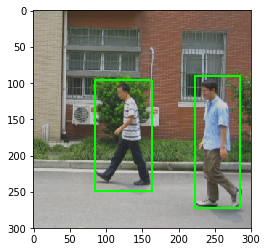

Inference time: 1.1740221977233887
Boxes: 11
Mod time: 0.011196136474609375
NMS time: 0.00029468536376953125
42 62 125 273 person 0.9682472


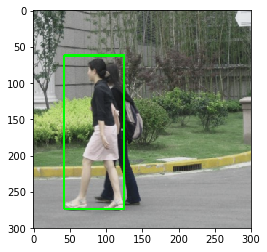

Inference time: 1.1804730892181396
Boxes: 12
Mod time: 0.011788368225097656
NMS time: 0.0009045600891113281
180 87 278 285 person 0.97668207


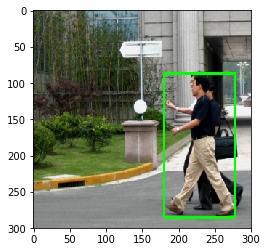

Inference time: 1.181337833404541
Boxes: 20
Mod time: 0.011246442794799805
NMS time: 0.00029587745666503906
126 44 245 260 person 0.970456
2 40 34 147 person 0.87964123


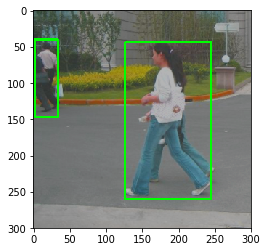

Inference time: 1.1792280673980713
Boxes: 17
Mod time: 0.012236833572387695
NMS time: 0.0002918243408203125
167 46 284 290 person 0.98754245
0 49 33 141 person 0.94173235


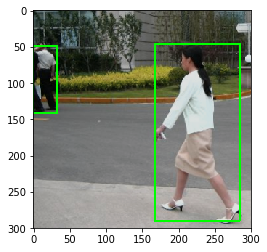

Inference time: 1.1833975315093994
Boxes: 25
Mod time: 0.012452840805053711
NMS time: 0.0003082752227783203
165 68 270 281 person 0.97730607
0 74 70 272 person 0.965127


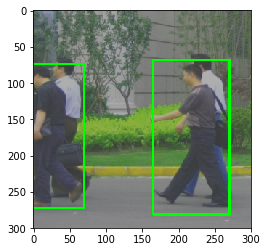

Inference time: 1.1605823040008545
Boxes: 21
Mod time: 0.01191854476928711
NMS time: 0.0003101825714111328
210 57 293 301 person 0.9944839
63 49 123 278 person 0.9768662


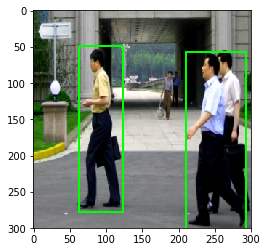

Inference time: 1.2006707191467285
Boxes: 22
Mod time: 0.012520551681518555
NMS time: 0.0003409385681152344
174 102 284 296 person 0.96212465
27 116 86 247 person 0.87384677


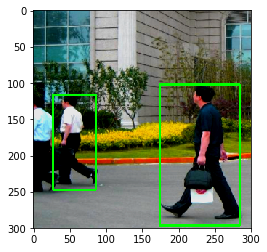

Inference time: 1.1756417751312256
Boxes: 28
Mod time: 0.012331008911132812
NMS time: 0.0005352497100830078
195 89 291 296 person 0.9916305
100 79 193 267 person 0.9696917


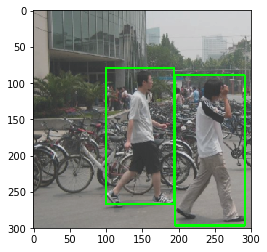

Inference time: 1.1809253692626953
Boxes: 10
Mod time: 0.012297391891479492
NMS time: 0.00031304359436035156
204 65 286 291 person 0.9896388


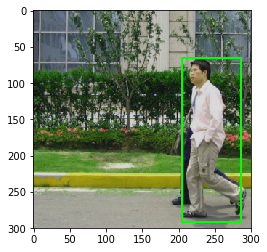

Inference time: 1.1897611618041992
Boxes: 15
Mod time: 0.012552022933959961
NMS time: 0.0003521442413330078
15 77 121 293 person 0.9886246


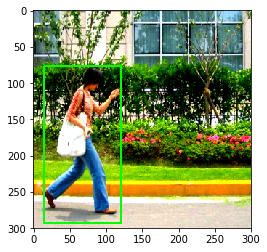

Inference time: 1.1622674465179443
Boxes: 22
Mod time: 0.012259960174560547
NMS time: 0.0006241798400878906
210 41 283 253 person 0.9977094
101 55 188 282 person 0.97417057


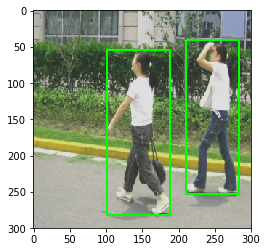

Inference time: 1.211329698562622
Boxes: 7
Mod time: 0.012801647186279297
NMS time: 0.0004353523254394531
177 114 253 287 person 0.97158843


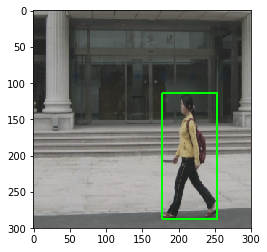

Inference time: 1.1794185638427734
Boxes: 14
Mod time: 0.012137651443481445
NMS time: 0.00043964385986328125
33 62 144 283 person 0.9834932


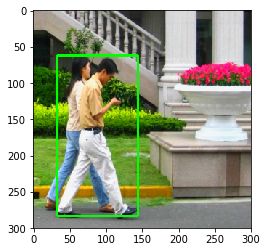

Inference time: 1.190629005432129
Boxes: 9
Mod time: 0.011933565139770508
NMS time: 0.00032830238342285156
19 34 150 281 person 0.9806683


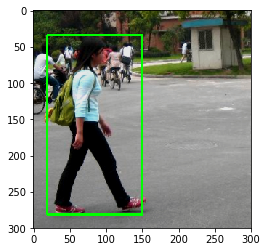

In [0]:
dboxes = default_boxes_300()
# dd = PennFudanDataset('./PennFudanPed', transforms=SSDTransformVoc(dboxes))
test('./ssd300.pth', SSD(ResNet50Backbone(), classes=21), BoxUtils(dboxes), test_dataset, size=300, thresh=0.1,num=15)

As you see we get more near to dataset result from SSD then in YoloV1. And you should ask why YoloV1 was detecting people that were not labeled while SSD not. 

On my experience that is because:
- We have more capacity then in Yolo thus we have fewer situations where network not sure. More capacity with the same amount of data leads to more strong overfitting. Thus more regularization and augmentation needed to train the network. Or reduce backbone size for example to ResNet10
- We have anchor boxes that have exact aspect ratios instead of just whatever it will train like in Yolo. Thus it more aligned to the dataset

### Regularization
We will talk about it so I think it would be good to give some information to refresh your memory.

So what is Regularization? Describing in math terms it's a function that gives an additional penalty if the model has weights with high values(this happens when model overfitting). In simple words, it's an additional parametrization that controls spikiness of your result(basically how much it's overfitting)

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/Regularization.svg.png?raw=true" width="400"/>

*How much you predicted result should be looking like green "line" or blue "line".*

### Overfitting
When we talking about overfitting you shouldn't think about it like something bad, or mistake, or error. Overfitting is a normal thing that always happens when you are making a prediction on previously observed data. It happens not only with models but also with living creatures like me or you. If you will look at your thoughts, actions you will see that they highly correlate with what you hear saw, learned before.

So zero overfitting will mean that you don't learn, and that's not cool. 100% overfitting will say that you a nazi racist or something like that, that also not cool. So the truth is somewhere in the balance between these edges. And what were we and models wanna be :)

### Hard training examples

As we saw already above datasets are not ideal, and many of these things really make our life tough. Cause each imbalance, error in labeling, or even broken images making training harder and harder or even impossible. (in real cases you should always clean and prepare data before start learning of model)

Also when we are training some simple solutions like pedestrian detection above we can use simple learning rate strategy like just lowering the learning rate as we stuck. But on big multi-label datasets in some cases, this may not work or will make training much longer. 

This happens because space of our error function is not smoothly falling but very spiky with many local minimums from which sometimes very hard to get rid of (this can be changed with regularization and residual connections that making space of error function more smooth). Space of error function may look like this:

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/3D-View4.png?raw=true">
<div align="center">(Red is a global minimum of function)</div>
</br>

The more data with the same network we put, the harder for the network to learn, because it should make data more compressed(which means learn much harder features so distinguish data with much less amount of memory). And also because more data we have more unbalanced and more features we have.

You may think about this like when you choose something to buy. If I will give you 3-5 products you will choose best of it very fast, but if I'll give you 30 products which on first look seems the same it will take much longer to choose best of them(that's why the good seller will never propose too much of variants)

So you need to use harder strategies or control training manually.

Here are a few examples of different LR strategies which you can also mix together to make many interesting functions:


Cosine


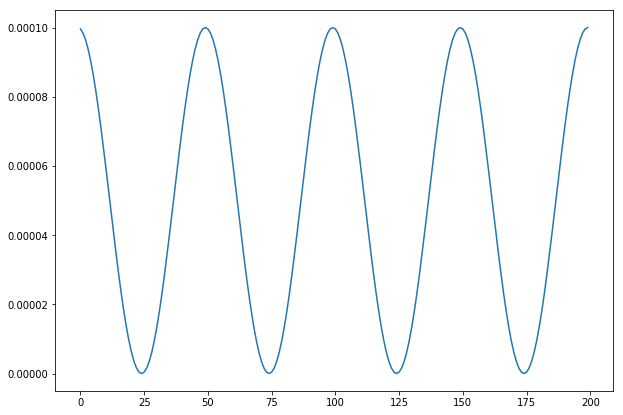

Cosine with stop


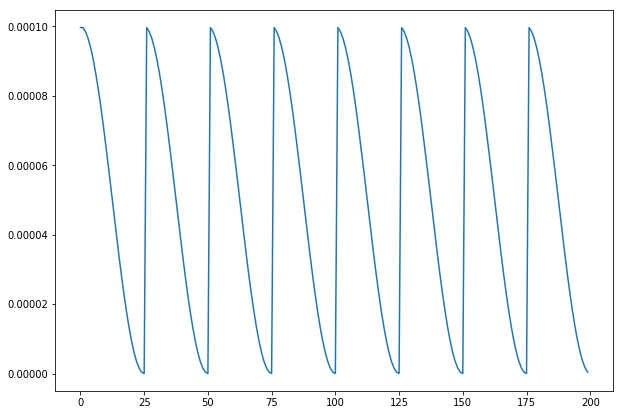

Cyclic


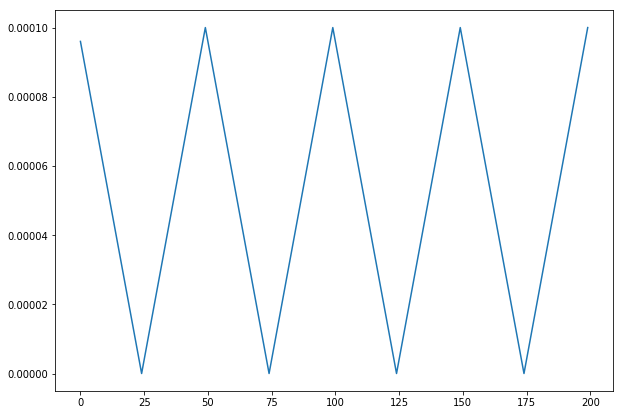

Cyclic with stop


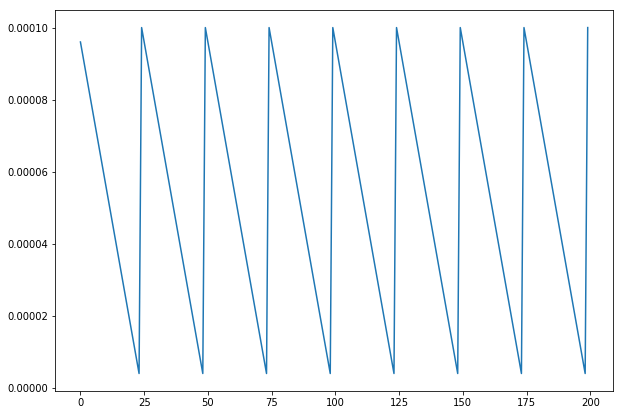

Cyclic steps with stop


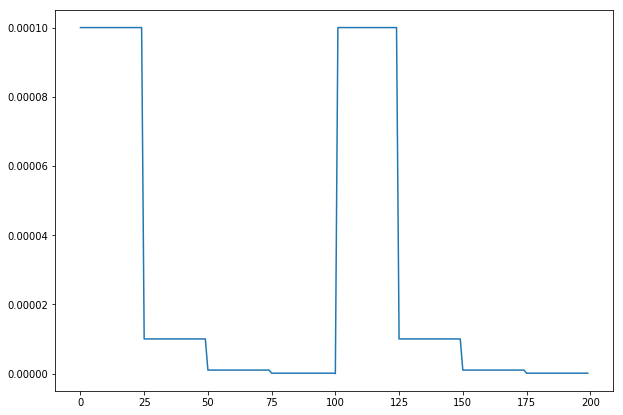

In [0]:
def cosine():
    model = torch.nn.Linear(1, 1)
    optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=5e-4)
    sc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 25, eta_min=1e-8)
    x,y = [],[]
    for i in range(200):
        x.append(i)
        optimizer.step()
        sc.step()
        y.append(optimizer.param_groups[0]['lr'])

    plt.figure(figsize=(10,7))
    plt.plot(x,y)
    plt.show()

def cosine_with_stop():
    model = torch.nn.Linear(1, 1)
    optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=5e-4)
    sc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 25, eta_min=1e-8)
    x,y = [],[]
    for i in range(200):
        x.append(i)
        optimizer.step()
        sc.step()
        y.append(optimizer.param_groups[0]['lr'])
        if i % 25 == 0:
            optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=5e-4)
            sc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 25, eta_min=1e-8)


    plt.figure(figsize=(10,7))
    plt.plot(x,y)
    plt.show()

def cyclic_steps():
    model = torch.nn.Linear(1, 1)
    optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=5e-4)
    sc = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
    x,y = [],[]
    for i in range(200):
        x.append(i)
        optimizer.step()
        sc.step()
        y.append(optimizer.param_groups[0]['lr'])
        if i % 100 == 0:
            optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=5e-4)
            sc = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)


    plt.figure(figsize=(10,7))
    plt.plot(x,y)
    plt.show()

def cyclic():
    model = torch.nn.Linear(1, 1)
    optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=5e-4)
    sc = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 1e-8, step_size_up=25, step_size_down=25, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)
    x,y = [],[]
    for i in range(200):
        x.append(i)
        optimizer.step()
        sc.step()
        y.append(optimizer.param_groups[0]['lr'])

    plt.figure(figsize=(10,7))
    plt.plot(x,y)
    plt.show()

def cyclic_with_stop():
    model = torch.nn.Linear(1, 1)
    optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=5e-4)
    sc = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 1e-8, step_size_up=25, step_size_down=0, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)
    x,y = [],[]
    for i in range(200):
        x.append(i)
        optimizer.step()
        sc.step()
        y.append(optimizer.param_groups[0]['lr'])

    plt.figure(figsize=(10,7))
    plt.plot(x,y)
    plt.show()

print('Cosine')
cosine()
print('Cosine with stop')
cosine_with_stop()
print('Cyclic')
cyclic()
print('Cyclic with stop')
cyclic_with_stop()
print('Cyclic steps with stop')
cyclic_steps()

This change of LR back and forth creating 2 things:
1. they help us to overcome local minimum
2. they are making some sort of regularization by killing overfit in mode with slightly bigger gradient, thus network can have worse results on the test set, but better results on new data.

We will use the last one LR strategy, but the first 100 steps will be training with loss 1e-3. This training can take a whole day, so we need to save checkpoints on google drive and maybe restart training few times if instance will be disconnected by timeout (don't close your browser window, cause after that instance will be stopped automatically)

#### **Warning, Don't kill the weights**
The height of these LR spikes on the plots above should be handled with care. The problem here that a very big spike can kill weights that were trained before. 

For example, you train your network and at some point in time you have LR = 1e-6,
and mean of weights in your model on some layer = 1e-7. Then you set LR to 1e-3 and get gradient with mean 1e-5, and this gradient killing weights cause it values much bigger than in weights tensor.

The same thing happening when you use a pre-trained network. If you run transfer learning on them with high LR, you will destroy most of the data. Thus in transfer learning, you first train top of the network with frozen backbone with high LR, and then when your LR goes to the 1e-5 - 1e-6, you unfreeze backbone and proceed training with such LR.

Another trick is to freeze the first layers of a pre-trained network, especially when you have synthetic data in the dataset. Because the first layers consist of low-level features and color distribution, they almost always the same. As for synthetic data, low-level distribution of it is different, thus on real examples, you will have accuracy drop ~ up to 40%


In [0]:
from google.colab import drive
# now your google drive on path ./drive
drive.mount('./drive')

1999642624it [00:40, 93946732.19it/s]                                

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./drive


### Tensorboard

During hard training (and it's a good thing to do always) we need to monitor our model params values distributions to know if our params are in good shape (params can be killed by gradient, in most cases, this means that our model architecture is not healthy. For example in deep networks it is better to use LeakyReLU instead of ReLU, cause the last one is known to kill model params(make them zeros)).

Another thing it's regularization. If we see that params values distribution variance are too big this can alert us that we can use some regularization there and reduce the overfitting of our model.

For this task, we will use Tensorboard which is part of the Torchvison module(writer) and UI is a part of Tensorflow. Also, we will need to make a tunnel from this instance to the web, and for this we need http://ngrok.com. Go there, register and copy auth token.

When training will stop, you may need to restart the script below.

In [0]:
os.makedirs('./runs/',exist_ok=True)
LOG_DIR = './runs'
AUTHTOKEN = '4bFy6iZFzxtQ2QLfyR75J_jYdEqABRNSDAuRXQTEwP'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -o ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok authtoken %s' % AUTHTOKEN )
get_ipython().system_raw('./ngrok http 6006 &')
print('Open new window with this link')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-10-07 10:32:55--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.223.24.224, 34.196.216.163, 52.203.61.249, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.223.24.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  28.6MB/s    in 0.5s    

2019-10-07 10:32:56 (28.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


1999642624it [02:50, 13443478.99it/s]                                

Open new window with this link
https://5426b8d0.ngrok.io


### Training VOC
Now let's train our model on the VOC dataset, it can take 6-9hours. if you don't want to wait you can download pre-trained weights by me (just uncomment the line below)

In [0]:
!wget https://learnml.s3.eu-north-1.amazonaws.com/ssd300_final.pth

--2019-11-21 08:25:48--  https://learnml.s3.eu-north-1.amazonaws.com/ssd300_final.pth
Resolving learnml.s3.eu-north-1.amazonaws.com (learnml.s3.eu-north-1.amazonaws.com)... 52.95.171.40
Connecting to learnml.s3.eu-north-1.amazonaws.com (learnml.s3.eu-north-1.amazonaws.com)|52.95.171.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61916499 (59M) [application/x-www-form-urlencoded]
Saving to: ‘ssd300_final.pth’

ssd300_final.pth    100%[===================>]  59.05M  76.7MB/s    in 0.8s    

2019-11-21 08:25:49 (76.7 MB/s) - ‘ssd300_final.pth’ saved [61916499/61916499]



In [0]:
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(42)

path_save = './ssd300.pth'
path_load = None
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

dboxes = default_boxes_300()
ds = datasets.VOCDetection('./voc', download=False, transforms=SSDTransformVoc(dboxes))
# to be able to test convergence result on data that network never sae, we split our dataset into traininig and test parts
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
# we will have same split here everytime because of setting manual seed
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

loader = DataLoader(train_dataset, batch_size=5, pin_memory=True, drop_last=True, shuffle=True) 
epochs = 1000 # its enough to see good result
device = torch.device("cuda")
model =  SSD(ResNet50Backbone(freeze=False), classes=21)
if path_load:
    print('Loading weights...')
    state = torch.load(path_load)
    model.load_state_dict(state)
model = model.to(device)
loss_f = Loss(hard_negative_minning=True)

# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)  

st = time.time()
model.train()
total_steps = 0
steps = 0
for e in range(epochs):
    t = 0
    loss_avg = 0
    for i, (img, target) in enumerate(loader):
        img = img.to(device)
        boxes, labels = target[0].to(device), target[1].to(device)
        # before each iteration we clear all gradients calculated before 
        optimizer.zero_grad()
        rboxes, rlabels = model(img)
        loss, m = loss_f(rboxes, rlabels, boxes, labels)
        # calculating gradients
        loss.backward()
        # optimizing
        optimizer.step()
        # .item() is simple way to get value from scalar
        loss_avg += loss.item()
        t += 1

        if t % 50 == 0:
            print(f'Step: {total_steps} Epoch: {e}/{epochs} Loss:{loss_avg/t} LR:{optimizer.param_groups[0]["lr"]}')

            writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], total_steps)
            writer.add_scalar('Loss', loss_avg/t, total_steps)
            # saving histograms of params
            for name, param in model.named_parameters():
                if param.requires_grad:
                    writer.add_histogram(name, param.data, total_steps)

            try:
                torch.save(model.state_dict(), path_save)
                writer.close()
            except KeyboardInterrupt as e:
                print('SAVING !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                torch.save(model.state_dict(), path_save)
                writer.close()
                raise e        

            total_steps += 1
            t = 0
            steps += 1
            loss_avg = 0

        if steps == 100:
            for g in optimizer.param_groups:
                g['lr'] *= 1e-4
        elif steps > 100:
                if steps and steps % 60 == 0:
                    for g in optimizer.param_groups:
                        g['lr'] *= 0.1
                
            if steps and and steps % 180 == 0:
                for g in optimizer.param_groups:
                    g['lr'] = 1e-4

    
print('Training time:', time.time()-st)

Loading weights...
Step: 0 Epoch: 0/1000 Loss:0.21018695309758187 LR:5e-05
Step: 1 Epoch: 0/1000 Loss:0.19187457218766213 LR:5e-05
Step: 2 Epoch: 0/1000 Loss:0.21628757521510125 LR:5e-05
Step: 3 Epoch: 0/1000 Loss:0.21816883936524392 LR:5e-05
Step: 4 Epoch: 0/1000 Loss:0.19282897412776948 LR:5e-05
Step: 5 Epoch: 0/1000 Loss:0.2094570004940033 LR:5e-05
Step: 6 Epoch: 0/1000 Loss:0.18947847276926041 LR:5e-05
Step: 7 Epoch: 0/1000 Loss:0.2060739640891552 LR:5e-05
Step: 8 Epoch: 0/1000 Loss:0.20880090355873107 LR:5e-05
Step: 9 Epoch: 0/1000 Loss:0.2072182509303093 LR:5e-05
Step: 10 Epoch: 0/1000 Loss:0.20915600135922433 LR:5e-05
Step: 11 Epoch: 0/1000 Loss:0.19265700206160546 LR:5e-05
Step: 12 Epoch: 0/1000 Loss:0.20922908514738084 LR:5e-05
Step: 13 Epoch: 0/1000 Loss:0.2009681683778763 LR:5e-05
Step: 14 Epoch: 0/1000 Loss:0.2112887167930603 LR:5e-05
Step: 15 Epoch: 0/1000 Loss:0.21191060230135916 LR:5e-05
Step: 16 Epoch: 0/1000 Loss:0.21816032946109773 LR:5e-05
Step: 17 Epoch: 0/1000 Loss

In [0]:
dboxes = default_boxes_300()
test('./ssd300_final.pth', SSD(ResNet50Backbone(), classes=21), BoxUtils(dboxes), test_dataset, size=300, thresh=0.8, iou_threshold=0.5 ,num=50)

# Summary and homework

This lecture shows us not only the difference between YoloV1 and SSD but also the difference between training on the small one-class dataset and big multi-class dataset. Now we know on practic how data can affect the convergence of model, and what we can do to handle that. 

## Homework

1. Try to run SSD300 on torchvision.datasets.CocoDetection (MSCOCO) dataset, and make it converge with using different LR strategies and augmentation.
2. Unfreeze ResNet model and see if that can help you to make the loss go down.
3. Calculate detection accuracy with IoU and classification with the mAP metric.

Questions can be asked here: https://github.com/learnml-today/object-detection-with-pytorch
